# **Part II - Image Inpainting**

The notebook includes all the code used for our project, and for each part we will explain the functionality.

In [ ]:
#Before you run !!!

#Make sure you have directory:
#'/content/drive/MyDrive/FinalProject'

#With the following files:
#'/content/drive/MyDrive/FinalProject/model_architecture.png'
#'/content/drive/MyDrive/FinalProject/states_tf_places2.pth'
#'/content/drive/MyDrive/FinalProject/test/yuval_image.jpg'
#'/content/drive/MyDrive/FinalProject/test/yuval_mask.png'
#'/content/drive/MyDrive/FinalProject/original_images_team1'
#'/content/drive/MyDrive/FinalProject/team1_mask'


## Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
import skimage.transform
import skimage.color
import skimage.io as io
from IPython.display import display
from PIL import ImageOps
from PIL import ImageDraw
import tensorflow as tf
from tensorflow.keras import layers
from keras.backend import clear_session
from pycocotools.coco import COCO
import matplotlib.image as mpimg
import cv2
from skimage import io, transform

plt.rcParams['figure.facecolor'] = 'white'

## Inpainting model functions


Based on the paper "Free-Form Image Inpainting with Gated Convolution": https://openaccess.thecvf.com/content_ICCV_2019/papers/Yu_Free-Form_Image_Inpainting_With_Gated_Convolution_ICCV_2019_paper.pdf  <br> <br>
The model is adapted from: https://github.com/nipponjo/deepfillv2-pytorch?tab=readme-ov-file

In [ ]:
#@title ##### Convolution

def _init_conv_layer(conv, activation, mode='fan_out'):
    """
    Initialize weights and biases of a convolutional layer based on the type of activation function used.

    Parameters:
    - conv (torch.nn.Module): The convolutional layer to initialize.
    - activation (torch.nn.Module): The activation function used in the layer.
    - mode (str, optional): The mode for weight initialization ('fan_out' or 'fan_in'). Default is 'fan_out'.
    """
    if isinstance(activation, nn.LeakyReLU):
        # Initialize weights using Kaiming initialization for LeakyReLU activation
        torch.nn.init.kaiming_uniform_(conv.weight,
                                       a=activation.negative_slope,
                                       nonlinearity='leaky_relu',
                                       mode=mode)
    elif isinstance(activation, (nn.ReLU, nn.ELU)):
        # Initialize weights using Kaiming initialization for ReLU or ELU activation
        torch.nn.init.kaiming_uniform_(conv.weight,
                                       nonlinearity='relu',
                                       mode=mode)
    else:
        pass
    if conv.bias is not None:
        # Initialize biases to zeros if they exist
        torch.nn.init.zeros_(conv.bias)

In [ ]:
#@title ##### Output to Image

def output_to_image(out):
    """
    Convert tensor output to image format.

    Parameters:
    - out (torch.Tensor): Output tensor to convert to image.

    Returns:
    - out (numpy.ndarray): Image representation of the output tensor.
    """
    # Move tensor to CPU, permute dimensions to bring channel dimension to the last axis, and adjust values to [0, 255] range
    out = (out[0].cpu().permute(1, 2, 0) + 1.) * 127.5
    # Convert tensor to numpy array of unsigned 8-bit integers
    out = out.to(torch.uint8).numpy()
    return out

In [ ]:
#@title ##### Padding

def same_padding(images, ksizes, strides, rates):
    """Implements tensorflow "SAME" padding as defined in:
       https://github.com/tensorflow/tensorflow/blob/8eaf671025e8cd5358278f91f7e89e2fbbe6a26b/tensorflow/core/kernels/ops_util.cc#L65
       see also: https://www.tensorflow.org/api_docs/python/tf/nn#same_padding_2

       Calculates and applies the necessary padding to input images to ensure that
       the output feature maps have the same spatial dimensions as the input images after convolution,
       considering the specified kernel size, strides, and dilation rates.
    """
    in_height, in_width = images.shape[2:]
    out_height = -(in_height // -strides[0])  # ceil(a/b) = -(a//-b)
    out_width = -(in_width // -strides[1])
    filter_height = (ksizes[0]-1)*rates[0] + 1
    filter_width = (ksizes[1]-1)*rates[1] + 1
    pad_along_height = max(
        (out_height-1)*strides[0] + filter_height - in_height, 0)
    pad_along_width = max(
        (out_width-1)*strides[1] + filter_width - in_width, 0)
    pad_top = pad_along_height // 2
    pad_bottom = pad_along_height - pad_top
    pad_left = pad_along_width // 2
    pad_right = pad_along_width - pad_left
    paddings = (pad_left, pad_right, pad_top, pad_bottom)
    padded_images = torch.nn.ZeroPad2d(paddings)(images)
    return padded_images

In [ ]:
#@title ##### Downsampling
def downsampling_nn_tf(images, n=2):
    """NN downsampling with tensorflow option align_corners=True \\
       Args:
           images: input
           n: downsampling factor
      performs downsampling of input images using nearest-neighbor interpolation,
      where each output pixel value is determined by the nearest pixel in the input image.
      This downsampling operation reduces the spatial dimensions of the input images by a
      factor of n along both height and width dimensions.
    """
    in_height, in_width = images.shape[2:]
    out_height, out_width = in_height // n, in_width // n
    height_inds = torch.linspace(0, in_height-1, steps=out_height, device=images.device).add_(0.5).floor_().long()
    width_inds = torch.linspace(0, in_width-1, steps=out_width, device=images.device).add_(0.5).floor_().long()
    return images[:, :, height_inds][..., width_inds]

In [ ]:
#@title ##### The Generator

class GConv(nn.Module):
    """Implements the gated 2D convolution introduced in
       `Free-Form Image Inpainting with Gated Convolution`(Yu et al., 2019) \\
        Uses the SAME padding from tensorflow.
    """

    def __init__(self,
                 cnum_in,
                 cnum_out,
                 ksize,
                 stride=1,
                 rate=1,
                 padding='same',
                 activation=nn.ELU()
                 ):

        super().__init__()

        self.activation = activation
        self.cnum_out = cnum_out
        num_conv_out = cnum_out if self.cnum_out == 3 or self.activation is None else 2*cnum_out
        self.conv = nn.Conv2d(cnum_in,
                              num_conv_out,
                              kernel_size=ksize,
                              stride=stride,
                              padding=0,
                              dilation=rate)

        _init_conv_layer(self.conv, activation=self.activation)

        self.ksize = ksize
        self.stride = stride
        self.rate = rate
        self.padding = padding

    def forward(self, x):
        x = same_padding(x, [self.ksize, self.ksize], [self.stride, self.stride],
                         [self.rate, self.rate])

        x = self.conv(x)
        if self.cnum_out == 3 or self.activation is None:
            return x
        x, y = torch.split(x, self.cnum_out, dim=1)
        x = self.activation(x)
        y = torch.sigmoid(y)
        x = x * y
        return x

#----------------------------------------------------------------------------

class GDeConv(nn.Module):
    """Upsampling followed by convolution"""

    def __init__(self, cnum_in,
                 cnum_out,
                 padding=1):
        super().__init__()
        self.conv = GConv(cnum_in, cnum_out, 3, 1,
                          padding=padding)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest',
                           recompute_scale_factor=False)
        x = self.conv(x)
        return x

#----------------------------------------------------------------------------

class Generator(nn.Module):
    def __init__(self, cnum_in=5, cnum=48, return_flow=False, checkpoint=None):
        super().__init__()

        # stage 1
        self.conv1 = GConv(cnum_in, cnum//2, 5, 1, padding=2)

        self.conv2_downsample = GConv(cnum//2, cnum, 3, 2)
        self.conv3 = GConv(cnum, cnum, 3, 1)
        self.conv4_downsample = GConv(cnum, 2*cnum, 3, 2)
        self.conv5 = GConv(2*cnum, 2*cnum, 3, 1)

        self.conv6 = GConv(2*cnum, 2*cnum, 3, 1)
        self.conv7_atrous = GConv(2*cnum, 2*cnum, 3, rate=2, padding=2) #Atrous = Dilated
        self.conv8_atrous = GConv(2*cnum, 2*cnum, 3, rate=4, padding=4)
        self.conv9_atrous = GConv(2*cnum, 2*cnum, 3, rate=8, padding=8)
        self.conv10_atrous = GConv(2*cnum, 2*cnum, 3, rate=16, padding=16)
        self.conv11 = GConv(2*cnum, 2*cnum, 3, 1)
        self.conv12 = GConv(2*cnum, 2*cnum, 3, 1)

        self.conv13_upsample = GDeConv(2*cnum, cnum)
        self.conv14 = GConv(cnum, cnum, 3, 1)
        self.conv15_upsample = GDeConv(cnum, cnum//2)
        self.conv16 = GConv(cnum//2, cnum//4, 3, 1)

        self.conv17 = GConv(cnum//4, 3, 3, 1, activation=None)
        self.tanh = nn.Tanh() #output between -1 and 1, suitable for image generation

        # stage 2
        # conv branch
        self.xconv1 = GConv(3, cnum//2, 5, 1, padding=2)

        self.xconv2_downsample = GConv(cnum//2, cnum//2, 3, 2)
        self.xconv3 = GConv(cnum//2, cnum, 3, 1)
        self.xconv4_downsample = GConv(cnum, cnum, 3, 2)
        self.xconv5 = GConv(cnum, 2*cnum, 3, 1)

        self.xconv6 = GConv(2*cnum, 2*cnum, 3, 1)
        self.xconv7_atrous = GConv(2*cnum, 2*cnum, 3, rate=2, padding=2)
        self.xconv8_atrous = GConv(2*cnum, 2*cnum, 3, rate=4, padding=4)
        self.xconv9_atrous = GConv(2*cnum, 2*cnum, 3, rate=8, padding=8)
        self.xconv10_atrous = GConv(2*cnum, 2*cnum, 3, rate=16, padding=16)

        # attention branch
        self.pmconv1 = GConv(3, cnum//2, 5, 1, padding=2)

        self.pmconv2_downsample = GConv(cnum//2, cnum//2, 3, 2)
        self.pmconv3 = GConv(cnum//2, cnum, 3, 1)
        self.pmconv4_downsample = GConv(cnum, 2*cnum, 3, 2)
        self.pmconv5 = GConv(2*cnum, 2*cnum, 3, 1)

        self.pmconv6 = GConv(2*cnum, 2*cnum, 3, 1, activation=nn.ReLU())
        self.contextual_attention = ContextualAttention(ksize=3,
                                                        stride=1,
                                                        rate=2,
                                                        fuse_k=3,
                                                        softmax_scale=10,
                                                        fuse=False,
                                                        device_ids=None,
                                                        n_down=2,
                                                        return_flow=return_flow)

        self.pmconv9 = GConv(2*cnum, 2*cnum, 3, 1)
        self.pmconv10 = GConv(2*cnum, 2*cnum, 3, 1)

        self.allconv11 = GConv(4*cnum, 2*cnum, 3, 1)
        self.allconv12 = GConv(2*cnum, 2*cnum, 3, 1)

        self.allconv13_upsample = GDeConv(2*cnum, cnum)
        self.allconv14 = GConv(cnum, cnum, 3, 1)
        self.allconv15_upsample = GDeConv(cnum, cnum//2)
        self.allconv16 = GConv(cnum//2, cnum//4, 3, 1)

        self.allconv17 = GConv(cnum//4, 3, 3, 1, activation=None)

        self.return_flow = return_flow

        if checkpoint is not None:
            generator_state_dict = torch.load(checkpoint)['G']
            self.load_state_dict(generator_state_dict, strict=True)
        self.eval();

    def forward(self, x, mask):
        xin = x

        # stage 1
        x = self.conv1(x)
        x = self.conv2_downsample(x)
        x = self.conv3(x)
        x = self.conv4_downsample(x)
        x = self.conv5(x)

        x = self.conv6(x)
        x = self.conv7_atrous(x)
        x = self.conv8_atrous(x)
        x = self.conv9_atrous(x)
        x = self.conv10_atrous(x)
        x = self.conv11(x)
        x = self.conv12(x)

        x = self.conv13_upsample(x)
        x = self.conv14(x)
        x = self.conv15_upsample(x)
        x = self.conv16(x)

        x = self.conv17(x)
        x = self.tanh(x)
        x_stage1 = x

        # stage2, paste result as input
        x = x*mask + xin[:, 0:3, :, :]*(1.-mask)

        # conv branch
        xnow = x
        x = self.xconv1(xnow)
        x = self.xconv2_downsample(x)
        x = self.xconv3(x)
        x = self.xconv4_downsample(x)
        x = self.xconv5(x)

        x = self.xconv6(x)
        x = self.xconv7_atrous(x)
        x = self.xconv8_atrous(x)
        x = self.xconv9_atrous(x)
        x = self.xconv10_atrous(x)
        x_hallu = x

        # attention branch
        x = self.pmconv1(xnow)
        x = self.pmconv2_downsample(x)
        x = self.pmconv3(x)
        x = self.pmconv4_downsample(x)
        x = self.pmconv5(x)

        x = self.pmconv6(x)
        x, offset_flow = self.contextual_attention(x, x, mask)
        x = self.pmconv9(x)
        x = self.pmconv10(x)
        pm = x
        x = torch.cat([x_hallu, pm], dim=1)

        x = self.allconv11(x)
        x = self.allconv12(x)
        x = self.allconv13_upsample(x)
        x = self.allconv14(x)
        x = self.allconv15_upsample(x)
        x = self.allconv16(x)

        x = self.allconv17(x)
        x = self.tanh(x)
        x_stage2 = x

        if self.return_flow:
            return x_stage1, x_stage2, offset_flow

        return x_stage1, x_stage2

    @torch.inference_mode()
    def infer(self,
              image,
              mask,
              return_vals=['inpainted', 'stage1'],
              device='cuda'):
        """
        Args:
            image:
            mask:
            return_vals: inpainted, stage1, stage2, flow
        Returns:

        """

        _, h, w = image.shape
        grid = 8

        image = image[:3, :h//grid*grid, :w//grid*grid].unsqueeze(0)
        mask = mask[0:1, :h//grid*grid, :w//grid*grid].unsqueeze(0)

        image = (image*2 - 1.)  # map image values to [-1, 1] range
        # 1.: masked 0.: unmasked
        mask = (mask > 0.).to(dtype=torch.float32)

        image_masked = image * (1.-mask)  # mask image

        ones_x = torch.ones_like(image_masked)[:, 0:1, :, :]  # sketch channel
        x = torch.cat([image_masked, ones_x, ones_x*mask],
                      dim=1)  # concatenate channels

        if self.return_flow:
            x_stage1, x_stage2, offset_flow = self.forward(x, mask)
        else:
            x_stage1, x_stage2 = self.forward(x, mask)

        image_compl = image * (1.-mask) + x_stage2 * mask

        output = []
        for return_val in return_vals:
            if return_val.lower() == 'stage1':
                output.append(output_to_image(x_stage1))
            elif return_val.lower() == 'stage2':
                output.append(output_to_image(x_stage2))
            elif return_val.lower() == 'inpainted':
                output.append(output_to_image(image_compl))
            elif return_val.lower() == 'flow' and self.return_flow:
                output.append(offset_flow)
            else:
                print(f'Invalid return value: {return_val}')

        return output

In [ ]:
#@title ##### Contextual Attention

"""
adapted from: https://github.com/daa233/generative-inpainting-pytorch/blob/c6cdaea0427b37b5b38a3f48d4355abf9566c659/model/networks.py
"""
class ContextualAttention(nn.Module):
    """ Contextual attention layer implementation. \\
        Contextual attention is first introduced in publication: \\
        `Generative Image Inpainting with Contextual Attention`(Yu et al., 2019) \\
        Args:
            ksize: Kernel size for contextual attention
            stride: Stride for extracting patches from b
            rate: Dilation for matching
            softmax_scale: Scaled softmax for attention

        Captures contextual information between foreground and background features,
        allowing the model to focus on relevant regions during inpainting tasks
    """

    def __init__(self,
                 ksize=3,
                 stride=1,
                 rate=1,
                 fuse_k=3,
                 softmax_scale=10.,
                 n_down=2,
                 fuse=True,
                 return_flow=False,
                 device_ids=None):
        super(ContextualAttention, self).__init__()
        self.ksize = ksize
        self.stride = stride
        self.rate = rate
        self.fuse_k = fuse_k
        self.softmax_scale = softmax_scale
        self.fuse = fuse
        self.device_ids = device_ids
        self.n_down = n_down
        self.return_flow = return_flow

    def forward(self, f, b, mask=None):
        """
        Args:
            f: Input feature to match (foreground).
            b: Input feature for match (background).
            mask: Input mask for b, indicating patches not available.
        """
        device = f.device
        # get shapes
        raw_int_fs, raw_int_bs = list(f.size()), list(b.size())   # b*c*h*w

        # extract patches from background with stride and rate
        kernel = 2 * self.rate
        # raw_w is extracted for reconstruction
        raw_w = extract_image_patches(b, ksizes=[kernel, kernel],
                                         strides=[self.rate*self.stride,
                                                  self.rate*self.stride],
                                         rates=[1, 1], padding='same')  # [N, C*k*k, L]
        # raw_shape: [N, C, k, k, L]
        raw_w = raw_w.view(raw_int_bs[0], raw_int_bs[1], kernel, kernel, -1)
        raw_w = raw_w.permute(0, 4, 1, 2, 3)    # raw_shape: [N, L, C, k, k]
        raw_w_groups = torch.split(raw_w, 1, dim=0)

        # downscaling foreground option: downscaling both foreground and
        # background for matching and use original background for reconstruction.
        f = downsampling_nn_tf(f, n=self.rate)
        b = downsampling_nn_tf(b, n=self.rate)
        int_fs, int_bs = list(f.size()), list(b.size())   # b*c*h*w
        # split tensors along the batch dimension
        f_groups = torch.split(f, 1, dim=0)
        # w shape: [N, C*k*k, L]
        w = extract_image_patches(b, ksizes=[self.ksize, self.ksize],
                                     strides=[self.stride, self.stride],
                                     rates=[1, 1], padding='same')
        # w shape: [N, C, k, k, L]
        w = w.view(int_bs[0], int_bs[1], self.ksize, self.ksize, -1)
        w = w.permute(0, 4, 1, 2, 3)    # w shape: [N, L, C, k, k]
        w_groups = torch.split(w, 1, dim=0)

        # process mask
        if mask is None:
            mask = torch.zeros([int_bs[0], 1, int_bs[2], int_bs[3]], device=device)
        else:
            mask = downsampling_nn_tf(mask, n=(2**self.n_down)*self.rate)
        int_ms = list(mask.size())
        # m shape: [N, C*k*k, L]
        m = extract_image_patches(mask, ksizes=[self.ksize, self.ksize],
                                        strides=[self.stride, self.stride],
                                        rates=[1, 1], padding='same')
        # m shape: [N, C, k, k, L]
        m = m.view(int_ms[0], int_ms[1], self.ksize, self.ksize, -1)
        m = m.permute(0, 4, 1, 2, 3)    # m shape: [N, L, C, k, k]
        m = m[0]    # m shape: [L, C, k, k]

        # mm shape: [L, 1, 1, 1]
        mm = (torch.mean(m, axis=[1, 2, 3], keepdim=True) == 0.).to(torch.float32)
        mm = mm.permute(1, 0, 2, 3)  # mm shape: [1, L, 1, 1]

        y = []
        offsets = []
        k = self.fuse_k
        scale = self.softmax_scale    # to fit the PyTorch tensor image value range
        fuse_weight = torch.eye(k, device=device).view(1, 1, k, k)  # 1*1*k*k

        for xi, wi, raw_wi in zip(f_groups, w_groups, raw_w_groups):
            '''
            O => output channel as a conv filter
            I => input channel as a conv filter
            xi : separated tensor along batch dimension of front; (B=1, C=128, H=32, W=32)
            wi : separated patch tensor along batch dimension of back; (B=1, O=32*32, I=128, KH=3, KW=3)
            raw_wi : separated tensor along batch dimension of back; (B=1, I=32*32, O=128, KH=4, KW=4)
            '''
            # conv for compare
            wi = wi[0]  # [L, C, k, k]
            max_wi = torch.sqrt(torch.sum(torch.pow(wi, 2), dim=[1, 2, 3], keepdim=True)).clamp_min(1e-4)
            wi_normed = wi / max_wi
            # xi shape: [1, C, H, W], yi shape: [1, L, H, W]
            xi = same_padding(xi, [self.ksize, self.ksize], [1, 1], [1, 1])  # xi: 1*c*H*W
            yi = F.conv2d(xi, wi_normed, stride=1)   # [1, L, H, W]
            # conv implementation for fuse scores to encourage large patches
            if self.fuse:
                # make all of depth to spatial resolution
                # (B=1, I=1, H=32*32, W=32*32)
                yi = yi.view(1, 1, int_bs[2]*int_bs[3], int_fs[2]*int_fs[3])
                # (B=1, C=1, H=32*32, W=32*32)
                yi = same_padding(yi, [k, k], [1, 1], [1, 1])
                yi = F.conv2d(yi, fuse_weight, stride=1)
                # (B=1, 32, 32, 32, 32)
                yi = yi.contiguous().view(1, int_bs[2], int_bs[3], int_fs[2], int_fs[3])
                yi = yi.permute(0, 2, 1, 4, 3).contiguous()

                yi = yi.view(1, 1, int_bs[2]*int_bs[3], int_fs[2]*int_fs[3])
                yi = same_padding(yi, [k, k], [1, 1], [1, 1])
                yi = F.conv2d(yi, fuse_weight, stride=1)
                yi = yi.contiguous().view(1, int_bs[3], int_bs[2], int_fs[3], int_fs[2])
                yi = yi.permute(0, 2, 1, 4, 3).contiguous()
            # (B=1, C=32*32, H=32, W=32)
            yi = yi.view(1, int_bs[2] * int_bs[3], int_fs[2], int_fs[3])

            # softmax to match
            yi = yi * mm
            yi = F.softmax(yi*scale, dim=1)
            yi = yi * mm  # [1, L, H, W]

            if self.return_flow:
                offset = torch.argmax(yi, dim=1, keepdim=True)  # 1*1*H*W

                if int_bs != int_fs:
                    # Normalize the offset value to match foreground dimension
                    times = (int_fs[2]*int_fs[3])/(int_bs[2]*int_bs[3])
                    offset = ((offset + 1) * times - 1).to(torch.int64)
                offset = torch.cat([torch.div(offset, int_fs[3], rounding_mode='trunc'),
                                    offset % int_fs[3]], dim=1)  # 1*2*H*W

                offsets.append(offset)

            # deconv for patch pasting
            wi_center = raw_wi[0]
            yi = F.conv_transpose2d(yi, wi_center, stride=self.rate, padding=1) / 4.  # (B=1, C=128, H=64, W=64)
            y.append(yi)

        y = torch.cat(y, dim=0)  # back to the mini-batch
        y = y.contiguous().view(raw_int_fs)

        if not self.return_flow:
            return y, None

        offsets = torch.cat(offsets, dim=0)
        offsets = offsets.view(int_fs[0], 2, *int_fs[2:])

        # case1: visualize optical flow: minus current position
        h_add = torch.arange(int_fs[2], device=device).view([1, 1, int_fs[2], 1]).expand(int_fs[0], -1, -1, int_fs[3])
        w_add = torch.arange(int_fs[3], device=device).view([1, 1, 1, int_fs[3]]).expand(int_fs[0], -1, int_fs[2], -1)
        offsets = offsets - torch.cat([h_add, w_add], dim=1)
        # to flow image
        flow = torch.from_numpy(flow_to_image(offsets.permute(0, 2, 3, 1).detach().cpu().numpy())) / 255.
        flow = flow.permute(0, 3, 1, 2)
        # case2: visualize which pixels are attended
        # flow = torch.from_numpy(highlight_flow((offsets * mask.long()).detach().cpu().numpy()))

        if self.rate != 1:
            flow = F.interpolate(flow, scale_factor=self.rate, mode='bilinear', align_corners=True)

        return y, flow

#----------------------------------------------------------------------------

In [ ]:
#@title ##### Extracting and Coloring

def extract_image_patches(images, ksizes, strides, rates, padding='same'):
    """
    Extracts sliding local blocks \\
    see also: https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html
    Patching - breaking down a large picture into more managable units
    """

    if padding == 'same':
        images = same_padding(images, ksizes, strides, rates)
        padding = 0

    unfold = torch.nn.Unfold(kernel_size=ksizes,
                             stride=strides,
                             padding=padding,
                             dilation=rates
                             )
    patches = unfold(images)
    return patches  # [N, C*k*k, L], L is the total number of such blocks

#----------------------------------------------------------------------------

def flow_to_image(flow):
    """Transfer flow map to image.
    Part of code forked from flownet.
    """
    out = []
    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.
    maxrad = -1
    for i in range(flow.shape[0]):
        u = flow[i, :, :, 0]
        v = flow[i, :, :, 1]
        idxunknow = (abs(u) > 1e7) | (abs(v) > 1e7)
        u[idxunknow] = 0
        v[idxunknow] = 0
        maxu = max(maxu, np.max(u))
        minu = min(minu, np.min(u))
        maxv = max(maxv, np.max(v))
        minv = min(minv, np.min(v))
        rad = np.sqrt(u ** 2 + v ** 2)
        maxrad = max(maxrad, np.max(rad))
        u = u / (maxrad + np.finfo(float).eps)
        v = v / (maxrad + np.finfo(float).eps)
        img = compute_color(u, v)
        out.append(img)
    return np.float32(np.uint8(out))

#----------------------------------------------------------------------------

def compute_color(u, v):
    h, w = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0
    # colorwheel = COLORWHEEL
    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)
    rad = np.sqrt(u ** 2 + v ** 2)
    a = np.arctan2(-v, -u) / np.pi
    fk = (a + 1) / 2 * (ncols - 1) + 1
    k0 = np.floor(fk).astype(int)
    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1
    f = fk - k0
    for i in range(np.size(colorwheel, 1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0 - 1] / 255
        col1 = tmp[k1 - 1] / 255
        col = (1 - f) * col0 + f * col1
        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])
        notidx = np.logical_not(idx)
        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col * (1 - nanIdx)))
    return img

#----------------------------------------------------------------------------

def make_color_wheel():
    RY, YG, GC, CB, BM, MR = (15, 6, 4, 11, 13, 6)
    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros([ncols, 3])
    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255 * np.arange(0, RY) / RY))
    col += RY
    # YG
    colorwheel[col:col + YG, 0] = 255 - \
        np.transpose(np.floor(255 * np.arange(0, YG) / YG))
    colorwheel[col:col + YG, 1] = 255
    col += YG
    # GC
    colorwheel[col:col + GC, 1] = 255
    colorwheel[col:col + GC,
               2] = np.transpose(np.floor(255 * np.arange(0, GC) / GC))
    col += GC
    # CB
    colorwheel[col:col + CB, 1] = 255 - \
        np.transpose(np.floor(255 * np.arange(0, CB) / CB))
    colorwheel[col:col + CB, 2] = 255
    col += CB
    # BM
    colorwheel[col:col + BM, 2] = 255
    colorwheel[col:col + BM,
               0] = np.transpose(np.floor(255 * np.arange(0, BM) / BM))
    col += + BM
    # MR
    colorwheel[col:col + MR, 2] = 255 - \
        np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col + MR, 0] = 255
    return colorwheel


#----------------------------------------------------------------------------

## Mount the drive & Import model's weights
make sure you have all the files listed in the begining of the notebook

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Generators architecture summary

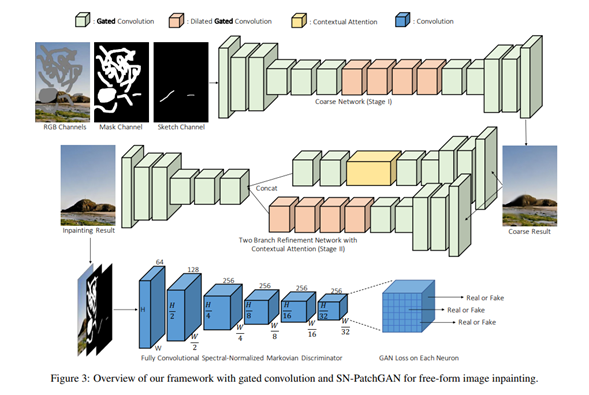

In [ ]:
Image.open('/content/drive/MyDrive/FinalProject/model_architecture.png')

#### Load generator model

In [ ]:
use_cuda_if_available = False
device = torch.device('cuda' if torch.cuda.is_available()
                             and use_cuda_if_available else 'cpu')

sd_path = '/content/drive/MyDrive/FinalProject/states_tf_places2.pth'

generator = Generator(checkpoint=sd_path, return_flow=True).to(device)

## Inpainitng example

#### Let's inpaint the picture we took before starting the project, with our model:

#### Load image and mask

In [ ]:
image_path = f"/content/drive/MyDrive/FinalProject/test/yuval_image.jpg"
mask_path = f"/content/drive/MyDrive/FinalProject/test/yuval_mask.png"

image_pil = Image.open(image_path)
mask_pil = Image.open(mask_path)

#### Inpaint

In [ ]:
image = T.ToTensor()(image_pil).to(device)
mask = T.ToTensor()(mask_pil).to(device)

output = generator.infer(image, mask, return_vals=['inpainted', 'stage1', 'stage2', 'flow'])

### Results

Result:


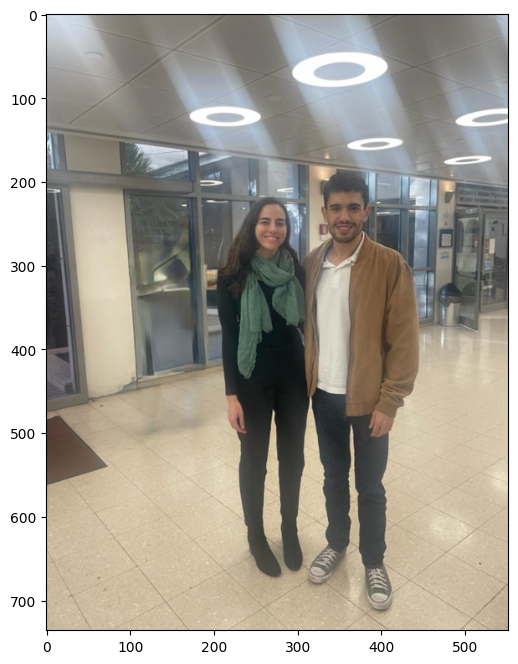

| Raw | Masked |
| Stage1 | Stage2 |


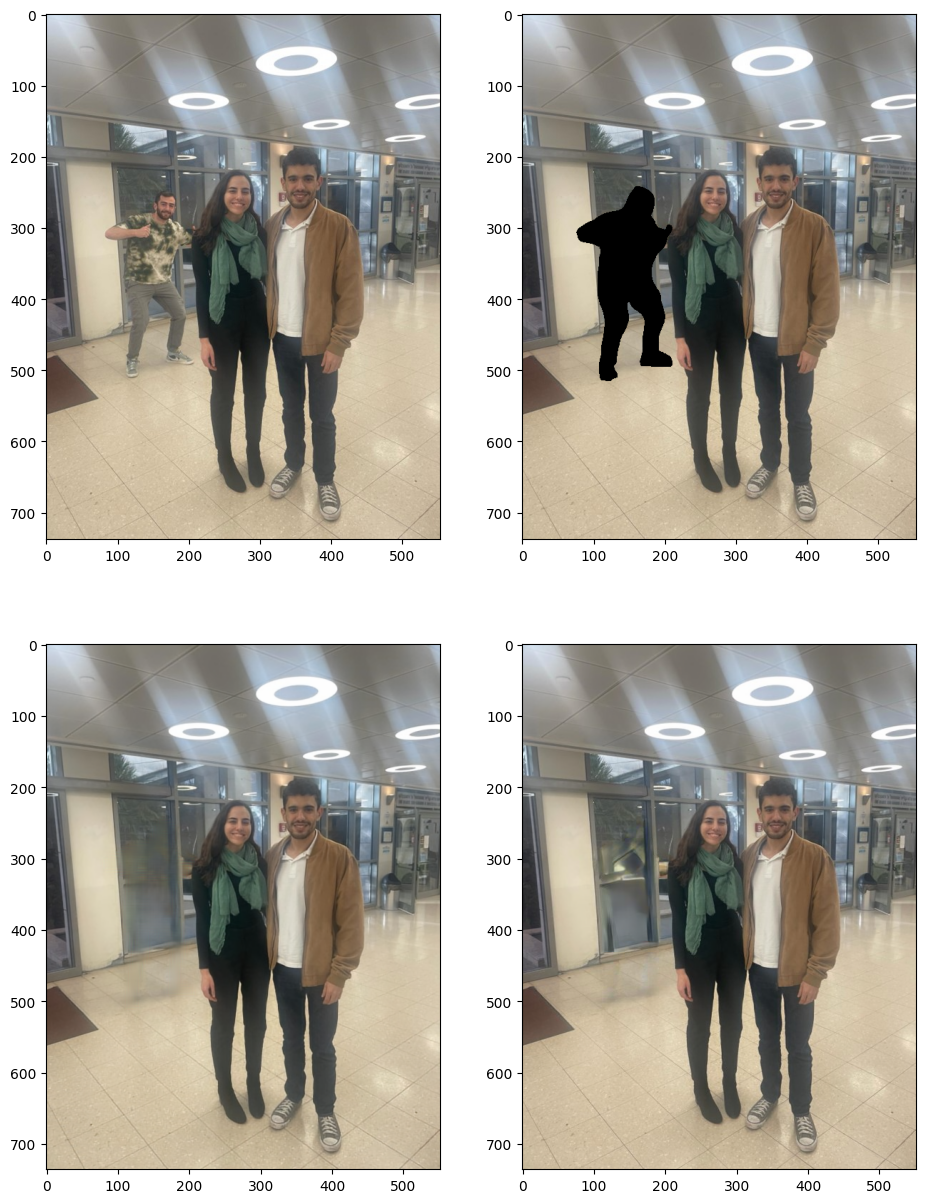

In [ ]:
mask = (mask[0:1] > 0.).to(dtype=torch.float32)
image_masked = (image*(1-mask)).permute(1, 2, 0).cpu()

print("Result:")
plt.figure(figsize=(10, 8))
plt.imshow(output[0])
plt.show()

w, h = image_pil.size

print("""| Raw | Masked |
| Stage1 | Stage2 |""")
_, axes = plt.subplots(2, 2, figsize=(15*w / max(w,h), 15*h / max(w,h)))
axes[0,0].imshow(image_pil)
axes[0,1].imshow(image_masked)
axes[1,0].imshow(output[1])
axes[1,1].imshow(output[2])
plt.show()

After conducting this sanity check and confirming that the model works, we will proceed to use it on our dataset.

## Inpainting pipeline

In [ ]:
def inpainting_pipe_by_image(image_path, mask_path, output_path, team1 = True):
    for image_name in os.listdir(image_path):
        try:
            # Open image and corresponding mask
            image_pil = Image.open(os.path.join(image_path, image_name))
            if team1:
              mask_pil = Image.open(os.path.join(mask_path, image_name))
            else:
              mask_pil = Image.open(os.path.join(mask_path, "mask_" + image_name))

            # Process images
            image = T.ToTensor()(image_pil).to(device)
            mask = T.ToTensor()(mask_pil).to(device)
            output = generator.infer(image, mask, return_vals=['inpainted', 'stage1', 'stage2', 'flow'])

            # Convert numpy array to PIL image to save
            output_image = Image.fromarray(output[0])
            output_image.save(os.path.join(output_path, image_name))
        except RuntimeError as e:
            print(f"RuntimeError occurred processing image {image_name}: {e}")
        except Exception as e:
            print(f"Error occurred processing image {image_name}: {e}")


## Mask modifitcation

In [ ]:
def adjust_rgba_mask(path):
    mask = Image.open(path)
    pixel_data = list(mask.getdata())

    # Create a new image with the same size and mode as the original image
    adjusted_im = Image.new('RGBA', mask.size)


    # Iterate over each pixel
    for i, pixel in enumerate(pixel_data):
        # Extract intensity value (since it's grayscale)
        intensity = pixel

        # Determine alpha value based on intensity
        if intensity == 0:
            alpha = 0
        else:
            alpha = 255

        # Set the pixel value with the determined alpha value
        new_pixel = (intensity,intensity,intensity, alpha)
        adjusted_im.putpixel((i % mask.width, i // mask.width), new_pixel)

    return adjusted_im

In [ ]:
def adjust_rgba_mask_team1(path):

  mask = Image.open(path)
  pixel_data = list(mask.getdata())

  # Create a new image with the same size and mode as the original image
  adjusted_im = Image.new(mask.mode, mask.size)

  # Iterate over each pixel
  for i, pixel in enumerate(pixel_data):
    # Extract RGB values
    r, g, b = pixel[:3]

    # Modify RGB values
    if (r, g, b) == (68, 1, 84):
      r, g, b = 0, 0, 0
    elif (r, g, b) == (253, 231, 36):
      r, g, b = 255, 255, 255

    # Determine alpha value based on modified RGB
    if (r, g, b) == (0, 0, 0):
      alpha = 0
    else:
      alpha = 255

    # Set the pixel value with the determined alpha value
    new_pixel = (r, g, b, alpha)
    adjusted_im.putpixel((i % mask.width, i // mask.width), new_pixel)

  return adjusted_im

In [ ]:
from PIL import Image, ImageDraw

def blobify(mask, radius):
    # Create a new image with the same size and mode as the original mask image
    blob_mask = Image.new('RGBA', mask.size)

    # Create a drawing context
    draw = ImageDraw.Draw(blob_mask)

    # Iterate over each pixel in the mask image
    for y in range(mask.size[1]):
        for x in range(mask.size[0]):
            # Get the pixel value at the current coordinates
            pixel = mask.getpixel((x, y))

            # Check if the pixel is part of the cluster (white)
            if pixel == (255, 255, 255, 255):
                # Draw a rounded rectangle centered around the pixel
                x1, y1 = x - radius, y - radius
                x2, y2 = x + radius, y + radius
                draw.ellipse([(x1, y1), (x2, y2)], fill=(255, 255, 255, 255))

    # Merge the modified image with the rounded rectangles
    blob_mask = Image.alpha_composite(mask.convert('RGBA'), blob_mask)

    # Delete the drawing context
    del draw

    return blob_mask

## Mask modification pipeline

In [ ]:
def modification_pipe(path_input, dir_output, radius, team1):
    if os.path.isdir(path_input):
        for filename in os.listdir(path_input):
            file_path = os.path.join(path_input, filename)
            if os.path.isfile(file_path):
                try:
                    # Choose the appropriate adjust_rgba_mask function based on the 'team1' flag
                    if team1:
                        adj_mask = adjust_rgba_mask_team1(file_path)
                    else:
                        adj_mask = adjust_rgba_mask(file_path)

                    # Apply blobification
                    mod_mask = blobify(adj_mask, radius)

                    # Save the modified mask to the output directory
                    output_file_path = os.path.join(dir_output, filename)
                    mod_mask.save(output_file_path)
                    print(f"Saved modified mask to {output_file_path}")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
            else:
                print(f"{file_path} is not a file. Skipping...")
    else:
        print("The input path does not exist or is not a directory.")
    print("Done!")

# Inpainting

We will utilize our inpainting model to process the same image twice. Firstly, we will employ the official masks for inpainting, followed by the masks generated by team #1. This approach allows us to evaluate the model's efficiency and performance without being reliant on the quality of the mask. By comparing the results obtained from both sets of masks, we can gain valuable insights into the effectiveness of the inpainting model under different conditions.

### Paths

In [ ]:
# Define paths
image_path = '/content/drive/MyDrive/FinalProject/original_images'
image_path_team1 = '/content/drive/MyDrive/FinalProject/original_images_team1'
mask_path = '/content/drive/MyDrive/FinalProject/modified_masks'
mask_path_team1 = '/content/drive/MyDrive/FinalProject/modified_masks_team1'
output_path = '/content/drive/MyDrive/FinalProject/inpainted_images'
output_path_team1 = '/content/drive/MyDrive/FinalProject/inpainted_images_team1'

# Create directories if they don't exist
os.makedirs(image_path, exist_ok=True)
os.makedirs(image_path_team1, exist_ok=True)
os.makedirs(mask_path, exist_ok=True)
os.makedirs(mask_path_team1, exist_ok=True)
os.makedirs(output_path, exist_ok=True)
os.makedirs(output_path_team1, exist_ok=True)

In [ ]:
os.makedirs(mask_path_team1, exist_ok=True)

## Use pipline on COCO dataset test set with the official mask

### Download the test set that was used in part 1, and use the offficial mask for inpainting

In [ ]:
MAX_NUM_IMAGES = 2560
BASE_DIR = '/content'

In [ ]:
if not os.path.exists(f"{BASE_DIR}/annotations_trainval2017.zip"):
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip -o annotations_trainval2017.zip

In [ ]:
trainDataType = 'train2017'

trainAnnFile = f'{BASE_DIR}/annotations/instances_{trainDataType}.json'

STORED_IMAGE_DIR = f'{BASE_DIR}/images'

In [ ]:
coco=COCO(trainAnnFile)

In [ ]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

In [ ]:
CATEGORY_IDS = coco.getCatIds(catNms=['person'])
_image_ids = list(set(coco.getImgIds(catIds=CATEGORY_IDS)))  # Make sure there are no duplications
UNUSED_IMAGE_IDS = _image_ids[MAX_NUM_IMAGES:]
IMAGE_IDS = _image_ids[2304:2560] # These are the images used for test from team #1 model
IMAGE_SIZE = (512, 512)

In [ ]:
target_dir = "/content/drive/My Drive/FinalProject/COCO_dataset"
os.makedirs(target_dir, exist_ok=True)

mask_target_dir = "/content/drive/My Drive/FinalProject/COCO_dataset_mask"
os.makedirs(mask_target_dir, exist_ok=True)  # Create the target directory if it doesn't exist

image_target_dir = image_path

In [ ]:
def get_mask(images_ids: list[int], category_ids: list[int], MIN_MASK_CAPACITY_PERCENTAGE: float = 0.1, IMAGE_SIZE: tuple = (224, 224)):
    # Create list to store image IDs that don't meet mask capacity percentage
    dont_use = []
    i = 0
    # Loop through each image ID
    for image_id in images_ids:
        #download image
        coco.download(tarDir=target_dir, imgIds=[image_id])
        image_path = f"{target_dir}/{image_id:012d}.jpg"

        # Load annotations for the specified image ID and category IDs
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id, catIds=category_ids))

        # Load the corresponding image
        image = io.imread(image_path)
        n_image = image / 255.  # Normalize image

        # Create an empty mask
        mask = np.zeros((n_image.shape[0], n_image.shape[1]), dtype=np.uint8)

        # Draw segmentation masks on the empty mask
        for annotation in annotations:
            segmentation_mask = coco.annToMask(annotation)
            if segmentation_mask.shape != mask.shape:
                # Resize the segmentation mask to match the shape of the empty mask
                segmentation_mask = cv2.resize(segmentation_mask, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_NEAREST)
            mask += segmentation_mask

        # Apply binary thresholding to the mask
        mask[mask >= 1] = 255

        # Check if the mask meets the minimum capacity percentage
        mask_percentage = 0.05
        if mask.sum() <= mask.size * mask_percentage:
            # If not, add the image ID to the list of images not to use
            dont_use.append(image_id)

        # Resize image and mask
        image = transform.resize(image, IMAGE_SIZE, preserve_range=True, anti_aliasing=False).astype(np.uint8)
        mask = transform.resize(mask, IMAGE_SIZE, preserve_range=True, anti_aliasing=False)

        # Save the segmentation mask to the target directory
        mask_filename = f"mask_image_{i}.png"
        mask_path = os.path.join(mask_target_dir, mask_filename)
        cv2.imwrite(mask_path, mask)

        # Save the resized image to the target directory
        resized_image_filename = f"image_{i}.png"  # Adjust the filename as needed
        resized_image_path = os.path.join(image_target_dir, resized_image_filename)
        io.imsave(resized_image_path, image)  # Save the resized image

        # Display the image and segmentation mask
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title("Segmentation Mask")
        axes[1].axis("off")
        plt.show()
        i +=1

    return dont_use

In [ ]:
#a = get_mask(IMAGE_IDS, CATEGORY_IDS)

## Modify masks to fit the model format and to improve results by Blubifying

In [ ]:
mask_target_dir

'/content/drive/My Drive/FinalProject/COCO_dataset_mask'

In [ ]:
# For official masks
modification_pipe(mask_target_dir, mask_path, 10, team1 = False)

In [ ]:
# For team #1 masks
# Make sure you upload this file ['/content/drive/MyDrive/FinalProject/team1_mask'] to the directory before running
modification_pipe('/content/drive/MyDrive/FinalProject/team1_masks', mask_path_team1, 10, team1 = True)

## Inpaint the Test set with the offical masks

In [ ]:
def plot_image_and_mask(image_path, mask_path):
    # Open image and mask
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot image on the first subplot
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Plot mask on the second subplot
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


In [ ]:
'''def plot_images_with_masks(mask_dir, output_dir):
    # Get list of image files in mask directory
    image_files = os.listdir(mask_dir)

    # Iterate over each image file
    for image_file in image_files:
        # Construct paths for mask and output image
        mask_path = os.path.join(mask_dir, image_file)
        output_path = os.path.join(output_dir, image_file)

        # Plot image and mask side by side
        plot_image_and_mask(mask_path, output_path)

# Call the function for the specified directories
mask_path_team1 = '/content/drive/MyDrive/FinalProject/modified_masks_team1'
output_path_team1 = '/content/drive/MyDrive/FinalProject/original_images_team1'
plot_images_with_masks(mask_path_team1, output_path_team1)'''

In [ ]:
inpainting_pipe_by_image(image_path, mask_path, output_path,team1 = False)

RuntimeError occurred processing image image_7.png: Given groups=1, weight of size [48, 5, 5, 5], expected input[1, 3, 228, 228] to have 5 channels, but got 3 channels instead


### inpaint on the test set with team #1 masks

In [ ]:
inpainting_pipe_by_image(image_path_team1, mask_path_team1, output_path_team1)

# Evaluation

In [ ]:
def plot_images_side_by_side(image_paths, titles):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with three subplots

    for i, (image_path, title) in enumerate(zip(image_paths, titles)):
        try:
            # Load and display the image
            image = Image.open(image_path)
            axes[i].imshow(image)
            axes[i].set_title(title)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    plt.tight_layout()
    plt.show()

folder1_path = image_path
folder2_path = output_path_team1
folder3_path = output_path

# Get list of image files in each folder
for filename in os.listdir(folder1_path):
    try:
        # Select three images from each folder for plotting
        selected_images = [os.path.join(folder1_path, filename), os.path.join(folder3_path, filename), os.path.join(folder2_path, filename)]

        # Set titles for each image
        titles = ['original image', 'inpinting using original masks', 'inpainting using team #1 masks']

        # Plot the images side by side
        plot_images_side_by_side(selected_images, titles)
    except Exception as e:
        print(f"Error processing image {filename}: {e}")